# Laboratorio 5
## Integrantes: Arturo Lazcano y Sebastián Tapia

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import root
import time

# Parametros gráficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [2]:
# Función para plotear las trayectorias y control obtenidos
def plotter(t, X, u, title, sec_graph, path):
    X_1, X_2 = X

    axs = plt.GridSpec(2, 2, left=0.1, bottom=0.1, right=0.9, top=0.87, wspace=0.4, hspace=0.45)

    fig = plt.figure()
    fig.clf()

    ax1 = fig.add_subplot(axs[0, 0])
    ax2 = fig.add_subplot(axs[0, 1])
    ax3 = fig.add_subplot(axs[1, :])

    ax1.plot(t, X_1)
    ax1.plot(t[0], X_1[0], "*", label=r"$x_0$")
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$x(t)$")
    ax1.set_title("Producción valorizada en el tiempo")
    ax1.legend()

    sec_title, label = sec_graph
    ax2.plot(t, X_2)
    ax2.set_xlabel(r"$t$")
    ax2.set_ylabel(label)
    ax2.set_title(sec_title)

    ax3.plot(t, u)
    ax3.set_xlabel(r"$t$")
    ax3.set_ylabel(r"$u(t)$")
    ax3.set_title("Control óptimo")

    fig.suptitle(title, fontsize=16)

    #plt.savefig(path)
    plt.show()

In [3]:
# Funcion para plotear error en ejercicio 2
def plot_error(T, y_maxs, path, length=50):

    S = np.linspace(0, T, length)
    hjb_maxs = []
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    for i in range(len(y_maxs)):

        y_max = y_maxs[i]
        Y = np.linspace(y_min, y_max, length)
        y = np.linspace(0, y_max, len(S)*len(Y))
        hjb_array, hjb_max = HJB(S,Y)

        axs[i].plot(y, hjb_array)
        axs[i].set_title(r'HJB con $y_{\max}=$'+str(y_max))
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('HJB(s,y)')

        hjb_maxs += [hjb_max]

    fig.suptitle("Error HJB con T={}".format(T), fontsize=16)
    plt.tight_layout()
    #plt.savefig(path)
    plt.show()

    return hjb_maxs

# Ejercicio 1

Antes de implementar el método de tiro en Python, se buscará una expresión para el control óptimo de este problema utilizando el principio del máximo de Pontryagin.  

Por enunciado, $\dot{x} = x(t)u(t)$ con la condición inicial $x(0)=x_0>0$. También se define $c(t) = (1-u(t))x(t)$ a tiempo final fijo $T>1$ y $u(t) \in [0,1]$. Así, el problema resulta ser:

$$\displaystyle \max_{u(\cdot)} \int_0^T c(t)dt$$, 

o equivalentemente, 

$$\displaystyle -\min_{u(\cdot)} \int_0^T -c(t)dt$$.

Para utilizar el PMP, se verá el Hamiltoniano

$$H(t,x(t),u(t),p(t)) = l(x,u) + p(t)f(x,u) = (u(t)-1)x(t) + p(t)x(t)u(t)$$

Así, la dinámica del sistema adjunto viene dada por (simplificando la notación) $\dot{p} = -\partial_xH = 1-u+pu$ con la condición final $p(T) = 0$.  

Luego, para caracterizar el control óptimo, notar que,  
$\text{argmin}_u [x(u-1) + pxu] = \text{argmin}_u [ux(1+p)]$ pues solo interesa los términos que incluyan a $u(t)$.  

Por lo tanto, para minimizar la expresión $ux(1+p)$, se analiza el signo de $x(1+p)$. Sin embargo, como $\dot{x} = x(t)u(t)$ (lineal en $x$ y $u(t) \geq 0$), al resultar una solución de $x$ del tipo exponencial y con $x(0) = x_0 >0$, entonces $x(t)>0$ para todo $t$. Por lo que realmente interesa el signo de $1+p$. Entonces,  

$$
u(t) = \begin{cases} 
          1, \quad 1+p(t) < 0\\
          0, \quad 1+p(t) > 0\\
          \tilde{u}, \quad 1+p(t) = 0
\end{cases}
$$

Donde $\tilde{u}$ es libre. Se verá ahora que no se puede cumplir $1+p=0$.

Sea $\phi(t) = 1+p(t)$. Entonces, $\dot{\phi}(t) = \dot{p}(t) = 1-u+pu = 1-u(1+p) = 1-u\phi$.  

$$
\Longrightarrow \dot{\phi}(t) = \begin{cases} 
1, \quad 1+p(t)>0 \\
1, \quad 1+p(t)=0 \\
-p, \quad 1+p(t) < 0 \end{cases}
$$  

Pero en el caso que $1+p < 0$, entonces $p<-1 ⟺ -p>1$. Por lo que se concluye que $\dot{\phi} > 0$. Debido a lo anterior, si la trayectoria pasa por el cero, lo hará solo una vez. Así, el control óptimo del problema resulta:  

$$
u(t) = \begin{cases} 
          1, \quad 1+p(t) < 0\\
          0, \quad 1+p(t) \geq 0
\end{cases}
$$  

y que se define computacionalmente en el bloque siguiente.

In [4]:
# Control optimo
def u_tilde(p):
    if p < -1:
        return 1
    return 0

Se definen también la función $c(t)$ y la función $\int_0^t c(s)ds$ para observar su evolución en el tiempo y su valor final, que es el que se interesa maximizar.

In [5]:
# Consumo instantáneo
def c(t, z, u):
    x, p = z(t)
    return x * (1 - u(p))

# Consumo total
def f_obj(t, z, u):
    c_t = lambda t: -c(t, z, u)
    return quad(c_t, 0, t)[0]

## Método de tiro

El método de tiro, aplicado en este caso, consiste en encontrar el valor de $p(0)$ de modo que se tenga $p(T) = 0$. Para esto, se define una función con la EDO para $x(t)$ y la obtenida para $p(t)$., y una función $R(p_0, x_0, T)$ que recibe las condiciones iniciales del sistema de EDO's y el tiempo final, resuelve las ecuaciones y arroja el valor de $p(T)$.

Dada la definición de $R$, fijando $x_0$ y $T$, se cumple que los ceros de $R$ corresponden a los $p_0$ tal que $p(T) = 0$. Luego, se utilizará la función ``fsolve`` para encontrar los ceros de $R$ y, por consiguiente, una condición inicial $p(0)$ tal que $p(T) = 0$.

In [6]:
# Función con EDO's
def F(t, z, u):
    x, p = z
    dx = x * u(p)
    dp = (1 - u(p)) - p * u(p)

    dz = np.array([dx, dp])
    return dz

In [7]:
# Arroja p(T)
def R(p_0, x_0, T, return_traj=False):
    t_i = time.time()
    t_to_solve = np.linspace(0, T, 1_000)

    sol = solve_ivp(F, [0, T], [x_0, p_0], t_eval=t_to_solve, args=[u_tilde], dense_output=True)
    t_f = time.time()
    dt = t_f - t_i
    z = sol.sol
    t = sol.t
    
    if return_traj:
        return z, t, dt

    P_T = z(T)[1]
    return P_T

Se puede observar directamente que $\dot{p}$ no depende de $x$, por lo que, al aplicar el método de tiro, se espera que el valor de $x_0$ no influya en los valores de $p(0)$. Por otro lado, se verá la tendencia que hay en los ceros de $R$ en función de $T$, probando para distintos tiempos finales y obteniendo un gráfico de $T$ vs $p(0)$.

In [8]:
# Prueba con varios tiempos T finales
x_0 = 5 # No influye
p_0_0 = 1
T_s = np.linspace(1.1, 8, 100)
sols = np.zeros(len(T_s))

for i in range(len(T_s)):
    sols[i] = fsolve(R, p_0_0, args=(x_0, T_s[i]))[0]

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


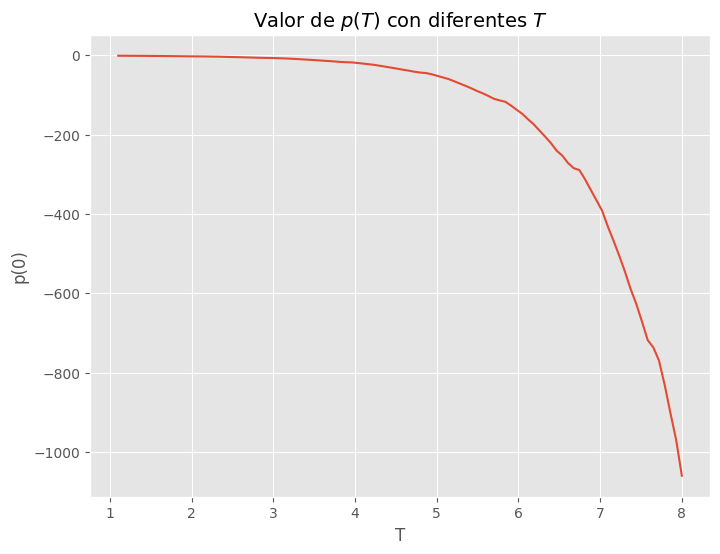

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(T_s, sols)

plt.title(r"Valor de $p(T)$ con diferentes $T$")
plt.xlabel("T")
plt.ylabel("p(0)")

#plt.savefig("/work/Lab_5/Ej_1/p_vs_T")
plt.show()

Se puede observar en el gráfico que a medida que aumenta $T$, el valor de $p(0)$ decrece hacia $-\infty$ de manera exponencial. Luego, $T$ influye fuertemente en la obtención de $p(0)$. 

Se mostrará ahora que el valor de $p(0)$ no cambia o no depende de los valores de $x_0$ que se tomen.

In [10]:
# Prueba con varios tiempos x_0
T = 2 # Tiempo final fijo
p_0_0 = 1
x_0_s = np.linspace(1, 20, 200)
sols = np.zeros(len(x_0_s))

for i in range(len(x_0_s)):
    sols[i] = fsolve(R, p_0_0, args=(x_0_s[i], T))[0]

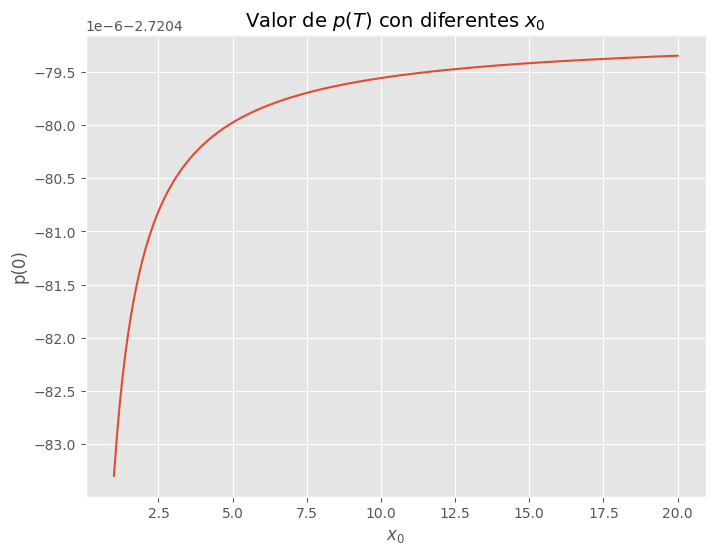

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(x_0_s, sols)

plt.title(r"Valor de $p(T)$ con diferentes $x_0$")
plt.xlabel(r"$x_0$")
plt.ylabel("p(0)")

#plt.savefig("/work/Lab_5/Ej_1/p_vs_x_0")
plt.show()

Se observa un crecimiento logaritmico mientras aumenta el $x_0$. Pero este gráfico es engañoso pues, observando la escala en el eje y, se ve que la variación es del orden de $10^{-6}$. Esto se observa claramente si se toma la diferencia entre el valor máximo y mínimo de los $p(0)$ obtenidos.

In [12]:
print("Diferencia min y max: ", np.fabs(sols.min() - sols.max()))

Diferencia min y max:  3.9497142370059635e-06


Como la diferencia es despreciable, se puede concluir que $x_0$ no influye en la obtención de $p(0)$.

A continuación se obtendrá la trayectoria, control óptimo y función objetivo de 0 a $t$ utilizando todas las combinaciones entre $x_0 = 5, 20$ y $T = 2, 5$, así como también los tiempos de ejecución y consumo total final.

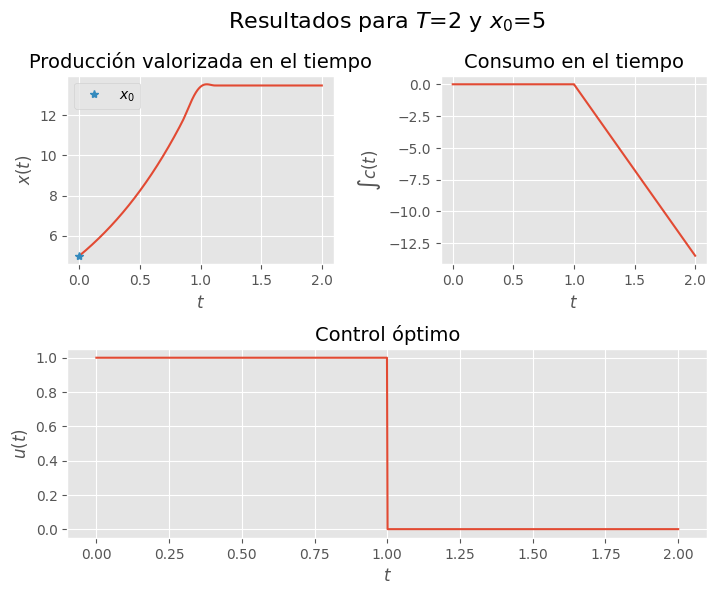

Tiempo de ejecución: 0.0015769004821777344 [s] con T = 2 y x_0 = 5
Valor objetivo: 13.487010132784263 con T = 2 y x_0 = 5
/tmp/ipykernel_233/1112111937.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(c_t, 0, t)[0]


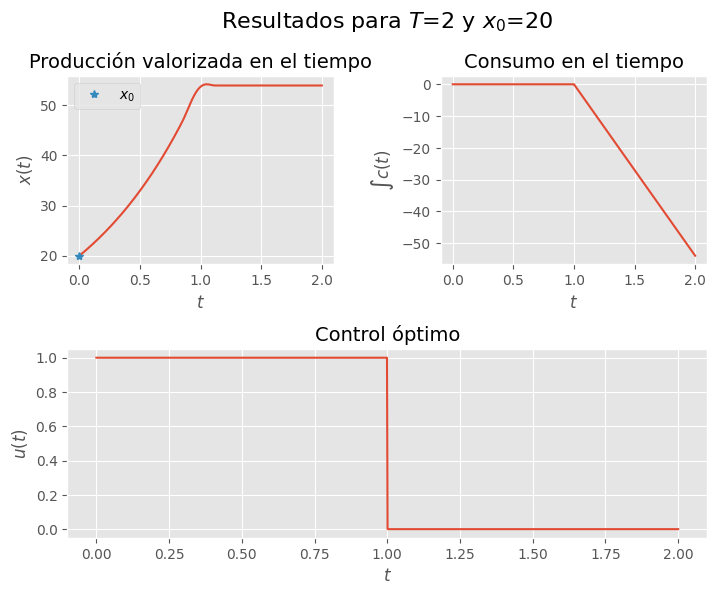

Tiempo de ejecución: 0.0015184879302978516 [s] con T = 2 y x_0 = 20
Valor objetivo: 53.94664163616299 con T = 2 y x_0 = 20


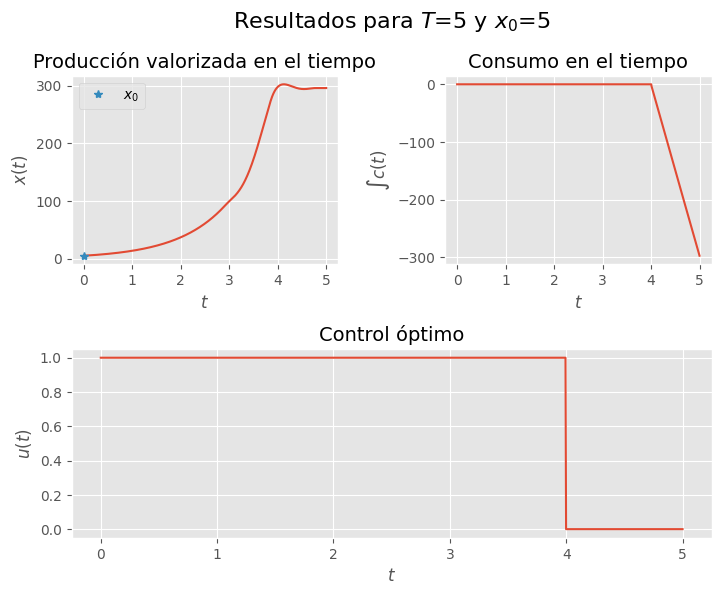

Tiempo de ejecución: 0.0018265247344970703 [s] con T = 5 y x_0 = 5
Valor objetivo: 297.5195880255574 con T = 5 y x_0 = 5


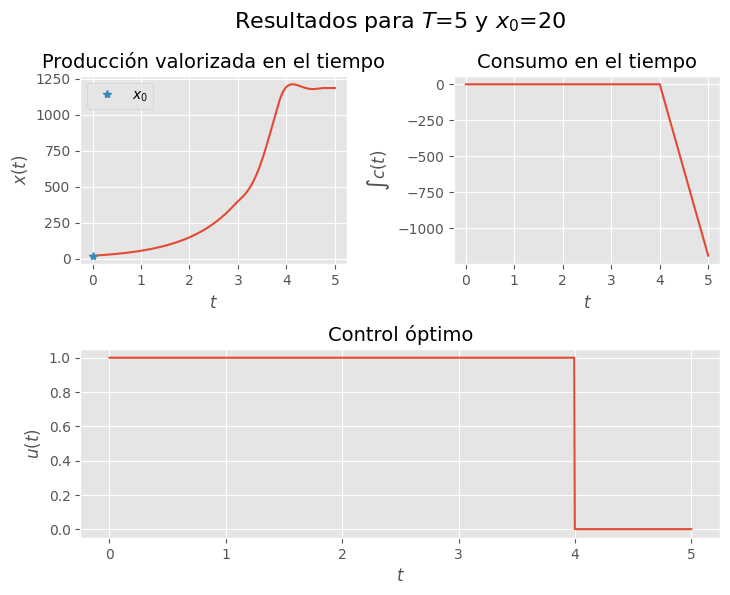

Tiempo de ejecución: 0.00148773193359375 [s] con T = 5 y x_0 = 20
Valor objetivo: 1190.0657466967123 con T = 5 y x_0 = 20


In [13]:
# T's y puntos iniciales a probar
T_1, T_2 = 2, 5
x_0_1, x_0_2 = 20, 5

for x_0, T in zip([x_0_2, x_0_1, x_0_2, x_0_1], [T_1, T_1, T_2, T_2]):

    # Obtiene raiz de R
    root = fsolve(R, 1, args=(x_0, T))

    # Resuelve
    z, t, dt = R(root, x_0, T, return_traj=True)

    x, p = z(t)

    u = np.zeros(len(p))
    obj_val_t = np.zeros(len(p))

    # Guarda control y valor objetivo en cada tiempo
    for i in range(len(p)):
        u[i] = u_tilde(p[i])
        obj_val_t[i] = f_obj(t[i], z, u_tilde)
    
    # Plotea
    plotter(t, [x, obj_val_t], u, r"Resultados para $T$={} y $x_0$={}".format(T, x_0), 
            ["Consumo en el tiempo", r"$\int c(t)$"], "/work/Lab_5/Ej_1/Resultados_T_"+str(T)+"_x0_"+str(x_0))

    # Imprime parámetros de comparación
    obj_val = f_obj(T, z, u_tilde)
    print("Tiempo de ejecución:", dt, "[s]", "con T =", T, "y x_0 =", x_0)
    print("Valor objetivo:", -obj_val, "con T =", T, "y x_0 =", x_0)

# Ejercicio 2

Se pide mostrar computacionalmente que la función 
$$
V(s, y)
\begin{cases}
 ye^{-s+T-1}& \text{ si } (s, y)\in [0, T-1) \times (0, \infty)\\
 y (T - s)& \text{ si } (s, y)\in [T-1, T) \times (0, \infty)
\end{cases}
$$
resuelve
$$
\partial_t V(s, y) + y + y\max_{w\in [0, 1]}\{w(\partial_x V(s, y) - 1)\} = 0, V(T, y) = 0.
$$
Para esto, se definirán ambas derivadas y se verá que cumplen la relación pedida para varios $s, y$ en los intervalos deseados.

In [14]:
# Función V
def V(s,y):
    if 0<=s<T-1 and y>0:
        return y * np.exp(-s+T-1)

    return y * (T - s)

In [15]:
# Derivadas

# Temporal
def V_t(s,y):
    if 0<=s<T-1:
        return -y*np.exp(-s+T-1)
    return -y

# Espacial
def V_x(s,y):
    if 0<=s<T-1 and y>0:
        return np.exp(-s+T-1)
    return T-s

Dado que lo que está dentro del máximo es lineal con respecto a $w$, basta ver el signo de lo que acompaña a $w$, es decir, basta ver el signo de $\partial_x V(s, y) - 1$. Si $\partial_x V(s, y) - 1 ≤ 0$ el valor que maximiza será $w=0$, mientras que si $\partial_x V(s, y) - 1 >0$, $w=1$ maximiza lo requerido.

In [16]:
# Euación de HJB
def HJB(S,Y):
    res = [] #resultado de la ec. (1)
    for s in S:
        for y in Y:
            maximo = 0

            # Si V_x - 1 es positivo
            if V_x(s,y)>1:
                maximo = V_x(s,y) - 1

            res += [V_t(s,y) + y + (y * maximo)]

    # Máximo en módulo
    max_res = np.max(np.fabs(res)) # Debe ser cercano a 0
    
    return res, max_res

Se probará en primera instancia para un tiempo $T=5$ y con varios $s, y$ en los intervalos requeridos, tomando $y$'s cada vez de mayor valor, pues se intenta emular que $y\in (0, \infty)$.

In [17]:
# Prueba para un tiempo final
T=5

# Guarda resultado de la ec. (1)
res = [] 

# Límites de y (cercanos al intervalo (0,+infinito))
y_min, y_max = 0.001, 1000

# Valores a tomar de (s,y)
S = np.linspace(0,T,100)
Y = np.linspace(y_min,y_max,500)

# Imprime máximo
print('max ec.(1):',HJB(S,Y)[1])

max ec.(1): 7.275957614183426e-12


Se observa que el mayor valor (en módulo) obtenido es muy cercano a 0, por lo que se puede intuir que los demás valores en el arreglo también son cercanos a 0. 

Se verá ahora para distintos $y_{\max}$, que representa el mayor valor a tomar para $y$, tomando cada vez valores $y_{\max}$ más grandes (tendiendolos a infinito). Se probará tomando $T=2$ y $T=5$.

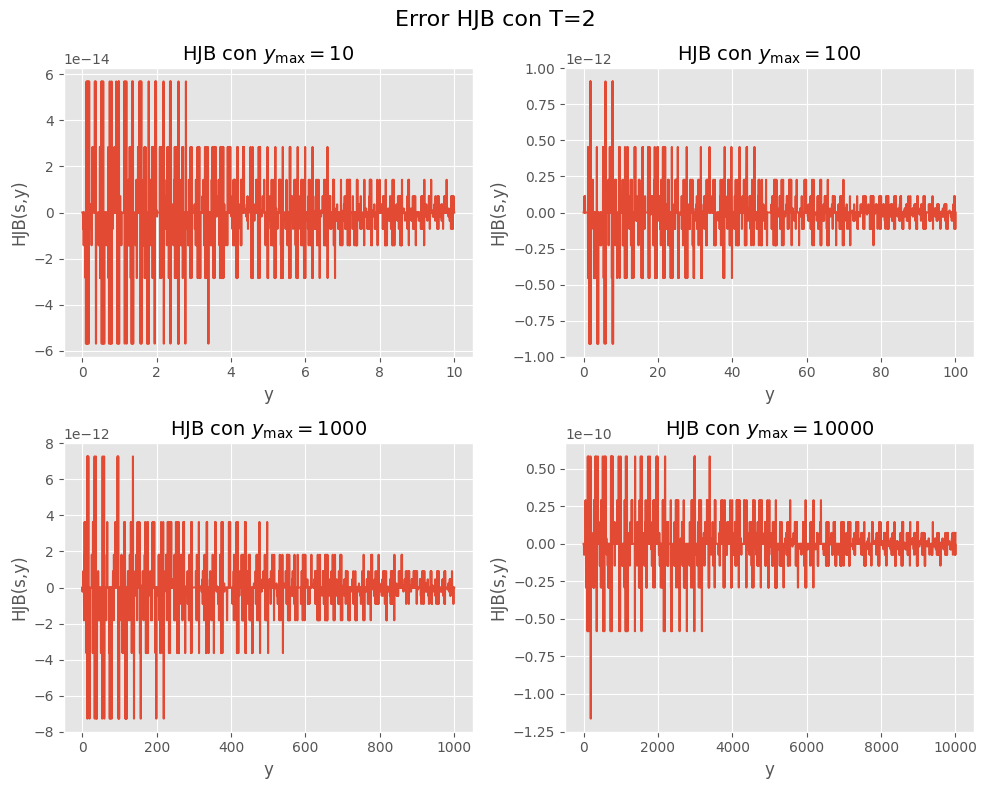

In [18]:
# Gráficos y_max tendiendo a infinito T = 2
y_maxs = [10, 100, 1_000, 10_000]
hjb_maxs = plot_error(T_1, y_maxs, "/work/Lab_5/Ej_2/Error_T_2")

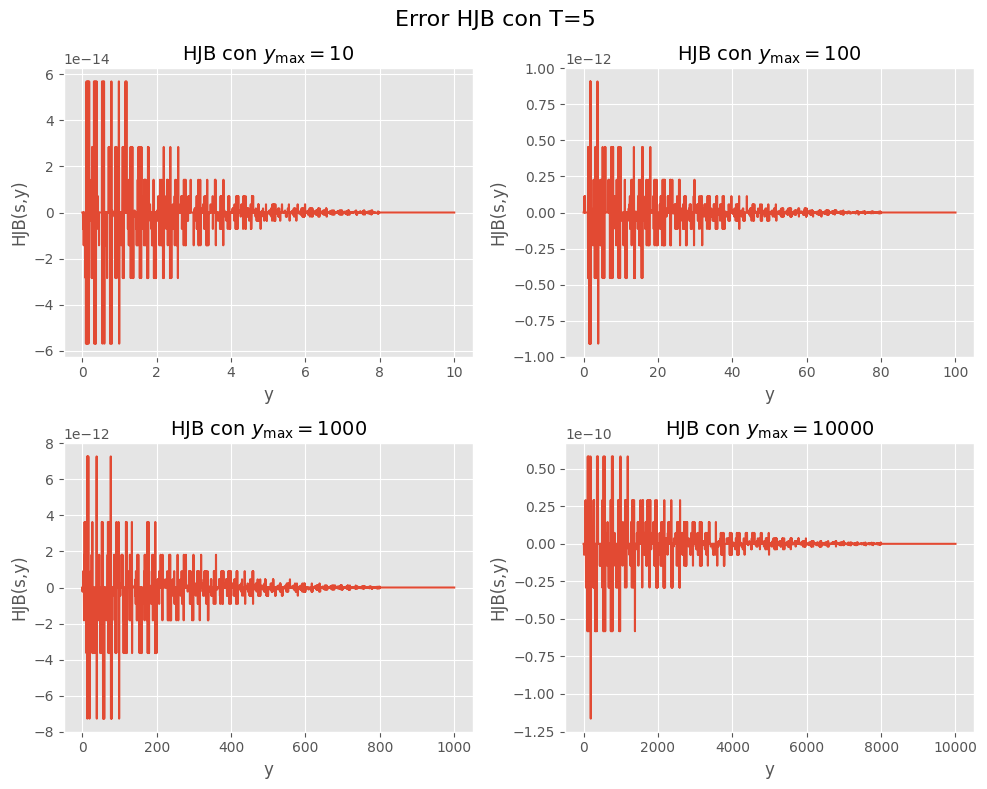

In [19]:
# Gráficos y_max tendiendo a infinito T = 5
hjb_maxs = plot_error(T_2, y_maxs, "/work/Lab_5/Ej_2/Error_T_5")

En los gráficos anteriores se puede ver que, a pesar de que el máximo valor que tome $y$ va incrementando, la ecuación de Hamilton-Jacobi-Bellman sigue cumpliendo que sea muy cercano a 0, o bien que computacionalmente es 0, que es lo que se pedía comprobar.

Por otro lado, cada vez que el valor de $y_{\max}$ incrementa, el valor máximo que toma la ecuación (1) también aumenta, sin embargo, este aumento es despreciable manteniendo así resultados coherentes.

Por último, se puede notar un ligero cambio en los valores máximos entre $T=2$ y $T=5$, pero que igualmente es una diferencia despreciable y la solución sigue cumpliendo que es 0.

# Ejercicio 3

Se tiene que $H(x, w, \partial_xV) = (w-1)x + \partial_xVxw = wx(1 + \partial_x V) - x$. Luego, el control feedback dado queda como 

$$
u = \underset{w\in[0, 1]}{\text{arg min}} \{H(x, w, \partial_xV)\} = \underset{w\in[0, 1]}{\text{arg min}} \{wx(1 + \partial_x V) - x\} 
$$
$$
= \underset{w\in[0, 1]}{\text{arg min}} \{wx(1 + \partial_x V)\},
$$
donde en el último paso se quitó $x$ porque no depende de $w$. Además, en el ejercicio 1 se obtuvo que $x>0$, por lo que no influirá en el cálculo de $u$ y se obtiene que $u = \underset{w\in[0, 1]}{\text{arg min}} \{w(1 + \partial_x V)\}$. Nuevamente se obtiene una función lineal con respecto a $w$, por lo que el control óptimo puede definirse como
$$
u=
\begin{cases}
 0 & \text{ si } 1 + \partial_xV ≥ 0 \\
 1 & \text{ si } 1 + \partial_xV < 0.
\end{cases}
$$

Vale decir que $\partial_x V$ no depende de $x$, por lo que la definición de $u$ se simplifica aún más.

In [20]:
# Control feedback
def u_arg(t):

    # Se setea x=1 pues DxV no depende de x
    DxV = lambda t: -V_x(t, 1)

    # Casos
    if DxV(t) < -1:
        return 1
    return 0

Se definen las funciones $c(t)$ y $\int_{0}^t c(s)ds$ para asi observar su evolución en el tiempo.

In [21]:
# Consumo instantáneo
def c(t, x, u):
    return x(t) * (1 - u(t))

# Consumo total
def f_obj(t, x, u):
    c_t = lambda t: -c(t, x, u)
    return quad(c_t, 0, t)[0]

In [22]:
# EDO para x
def func(t, x, u):
    dx = x * u(t)
    return dx

Se prueban todas las combinaciones posibles entre $x_0 = 5, 20$ y $T=2$, $T=5$, mostrando los gráficos de la trayectoria, valor objetivo y control óptimo, así como también el valor objetivo en el tiempo $T$ final y el tiempo de ejecución.

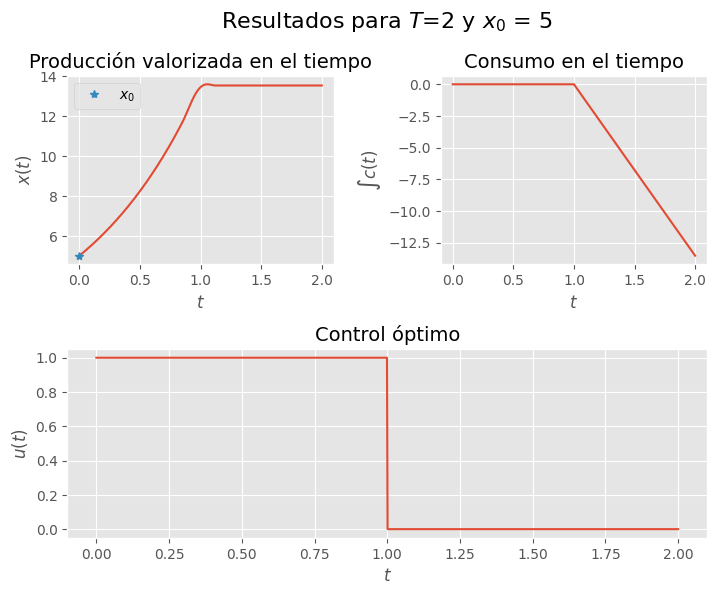

Tiempo de ejecución: 0.002913236618041992 [s] con T = 2 y x_0 = 5
Valor objetivo: 13.541635731228888 con T = 2 y x_0 = 5


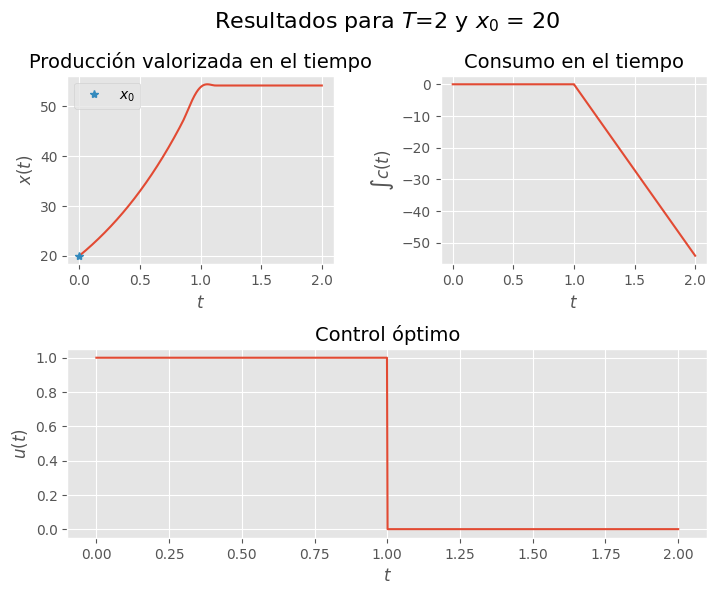

Tiempo de ejecución: 0.002425670623779297 [s] con T = 2 y x_0 = 20
Valor objetivo: 54.16472543028395 con T = 2 y x_0 = 20


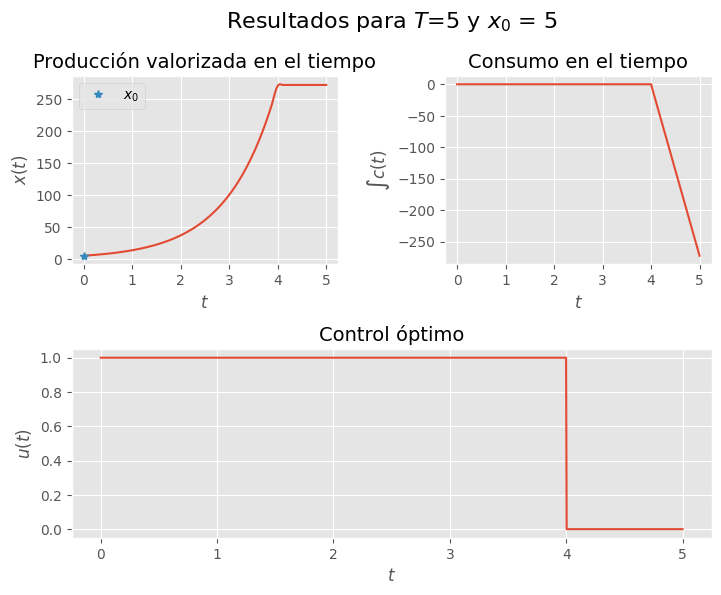

Tiempo de ejecución: 0.0046880245208740234 [s] con T = 5 y x_0 = 5
Valor objetivo: 272.5471525833551 con T = 5 y x_0 = 5


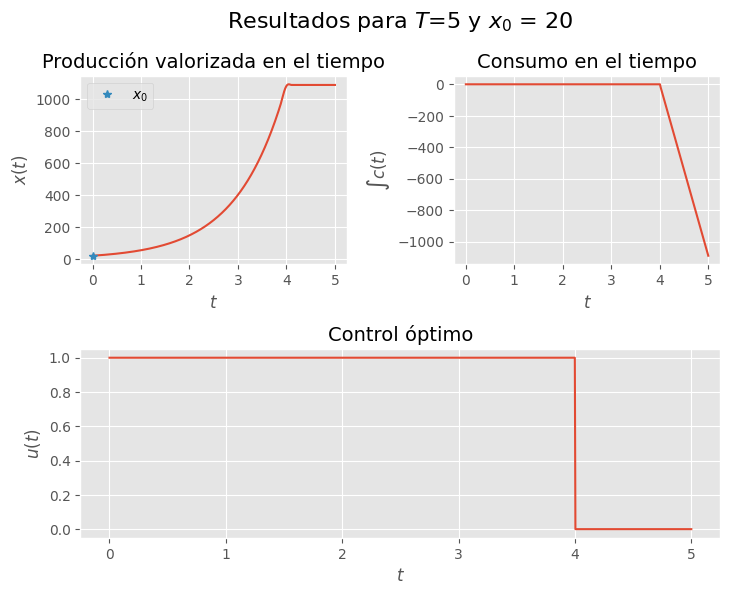

Tiempo de ejecución: 0.002999544143676758 [s] con T = 5 y x_0 = 20
Valor objetivo: 1090.1225392851322 con T = 5 y x_0 = 20


In [23]:
# Prueba para varios casos
for x_0, T in zip([x_0_2, x_0_1, x_0_2, x_0_1], [T_1, T_1, T_2, T_2]):

    # Tiempo a resolver
    t_to_solve = np.linspace(0, T, 1_000)

    # Resuelve y toma tiempo de ejecución
    t_i = time.time()
    solver = solve_ivp(func, [0, T], [x_0], t_eval=t_to_solve, args=[u_arg], dense_output=True)
    t_f = time.time()

    dt = t_f - t_i

    # Rescata resultados
    x = solver.y[0]
    x_t = solver.sol
    t = solver.t

    # Obtiene control y objetivo a tiempo t
    u = np.zeros(len(t))
    obj_val_t = np.zeros(len(t))
    for i in range(len(t)):
        u[i] = u_arg(t[i])
        obj_val_t[i] = f_obj(t[i], x_t, u_arg)

    # Plotea
    plotter(t, [x, obj_val_t], u, r"Resultados para $T$={} y $x_0$ = {}".format(T, x_0),
            ["Consumo en el tiempo", r"$\int c(t)$"], "/work/Lab_5/Ej_3/Resultados_T_"+str(T)+"_x0_"+str(x_0))

    # Imprime parámetros de comparación
    print("Tiempo de ejecución:", dt, "[s]", "con T =", T, "y x_0 =", x_0)
    print("Valor objetivo:", -obj_val_t[-1], "con T =", T, "y x_0 =", x_0)

# Ejercicio 4

Se ingresa el problema a bocop y se obtienen resultados para todas las combinaciones posibles entre $x_0=5$, $x_0=20$, $T=2$ y $T=5$.

### $x_0 = 5, T=2$
![title](Lab_5/Ej_4/bocopT2x05.png)

Se obtiene que el valor objetivo corresponde a -13.59 y con tiempo de ejecución de 0.18 segundos. Este valor representa el $\min -f$ por lo que debe multiplicarse por -1 para obtener el objetivo deseado. 


### $x_0 = 20, T=2$
![title](Lab_5/Ej_4/bocopT2x020.png)

Se obtiene que el valor objetivo corresponde a 54.37 con un tiempo de ejecución de 0.36 segundos.

### $x_0 = 5, T=5$
![title](Lab_5/Ej_4/bocopT5x05.png)

Se obtiene que el valor objetivo corresponde a 273 con un tiempo de ejecución de 0.5 segundos.

### $x_0 = 20, T=5$
![title](Lab_5/Ej_4/bocopT5x020.png)

Se obtiene que el valor objetivo corresponde a 1092 con un tiempo de ejecución de 0.41 segundos.

# Ejercicio 5

En resumen, se obtuvieron los siguientes valores objetivos y tiempos de ejecución para cada método:

### Método de tiro

*   Para $T=2$ y $x_0=5$: valor objetivo de 13.48 en 0.0014 [s]
*   Para $T=2$ y $x_0=20$: valor objetivo de 53.95 en 0.0016 [s]
*   Para $T=5$ y $x_0=5$: valor objetivo de 297.52 en 0.0017 [s]
*   Para $T=5$ y $x_0=20$: valor objetivo de 1190.07 en 0.0015 [s]

### Control feedback

*   Para $T=2$ y $x_0=5$: valor objetivo de 13.54 en 0.0034[s]
*   Para $T=2$ y $x_0=20$: valor objetivo de 54.16 en 0.0038 [s]
*   Para $T=5$ y $x_0=5$: valor objetivo de 272.55 en 0.0044 [s]
*   Para $T=5$ y $x_0=20$: valor objetivo de 1090.12 en 0.0038 [s]

### BOCOP

*   Para $T=2$ y $x_0=5$: valor objetivo de 13.59 en 0.18 [s]
*   Para $T=2$ y $x_0=20$: valor objetivo de 54.37 en 0.36 [s]
*   Para $T=5$ y $x_0=5$: valor objetivo de 273 en 0.5 [s]
*   Para $T=5$ y $x_0=20$: valor objetivo de 1092 en 0.41 [s]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8dad67a8-1530-43eb-8d35-31eaafb20d07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>